## FINAL PROJECT
Frederik Kallestrup Mastratis (qln174)  
Dongyu Liu (dlf327)  
Shamim Tariq Akram (zmx145)  
Celina Aurora Nguyen (szf345)  

Group 21

## PACKAGES

In [3]:
import numpy as np
import pandas as pd
import re
import datefinder
import requests

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import psycopg2

from cleantext import clean
from bs4 import BeautifulSoup as bs


In [4]:
df_test = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv", delimiter=",")

## TEXT CLEANER

In [5]:
DATE = '3[01]|[12][0-9]|0?[1-9]'
DATE_SUFFIXES = 'st|th|rd|nd'
DAY = '(mon|tues|thurs|fri|sun)(day)?|wed(nesday)?|sat(urday)?'
YEAR = '([12][0-9])?[0-9]{2}'
MONTHS = 'jan\.?(uary)?|feb\.?(ruary)?|mar\.?(ch)?|apr\.?(il)?|may|jun\.?(e)?|jul\.?(y)?|aug\.?(ust)?|sep\.?(tember)?|oct\.?(ober)?|nov\.?(ember)?|dec\.?(ember)?'

# format: pretty much all digit formats DD/MM/YY etc.
fd1 = '((%s)\s,?)?\d{1,4}[\\/-]\d{1,2}[\\/-]\d{1,4}' % (DAY)
# format: DD-DD MON (YYYY)
fd2 = '((%s)\s,?)?(%s)(%s)?(\s?-\s?(%s))?\s(%s)(\s?,?\s(%s))?' % (DAY, DATE, DATE_SUFFIXES, DATE, MONTHS, YEAR)
# format: MON DD-DD (YYYY)
fd3 = '((%s)\s,?)?(%s)\s(%s)(%s)?(\s?-\s?(%s))?(\s?,?\s(%s))?' % (DAY, MONTHS, DATE, DATE_SUFFIXES, DATE, YEAR)
# format: MON YYYY
fd4 = '(%s)\s(%s)?' % (MONTHS, YEAR)

DATES_REGEX = re.compile(r"(%s)|(%s)|(%s)|(%s)" % (fd1, fd2, fd3, fd4))

def clean_text(txt):
    txt = txt.lower()

    txt = re.sub(r"\s+", " ", txt)
    regex = {" EMAIL " : r"\w+@\w+(\.[a-z]{2})?\.[a-z]{2,3}",
        " URL " : r"([a-z\d]+://)?[a-z]+[a-z\d]*(\.[a-z\d\-\._~]+)+(/[a-z\d\-\._~]*|(\?[a-z\d\-\._~]+=[a-z\d\-\._~]+))*",
        " DATE " : DATES_REGEX,
        " NUM " : r"[+-]?((\d+(,|\.))*\d+)"}

    for k in regex.keys():
      txt = re.sub(regex[k], k, txt)

    txt = re.sub(r"/", "", txt)

    # Extra cleaning with cleantext library
    txt = clean(txt,
      lower=False,
      normalize_whitespace=True,
      no_line_breaks=True,
      strip_lines=True,
      no_numbers=True, replace_with_number= ' NUM ',
      no_urls=True, replace_with_url=' URL ',
      no_emails=True, replace_with_email=' EMAIL ',
      no_punct=True, replace_with_punct=''
    )

    tokens = word_tokenize(txt)
    prepostfix = lambda t: "<"+t+">" if t.isupper() else t
    tokens = list(map(prepostfix, tokens))

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    stemmer = SnowballStemmer(language='english')
    tokens = [stemmer.stem(w) if w[0] != '<' else w for w in tokens]

    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

In [28]:
##lemmatize
def tokenize_mood(txt):
  tokens = nltk.sent_tokenize(txt)
  prepostfix = lambda t: "<"+t+">" if t.isupper() else t
  return map(lambda sentence: map(prepostfix, sentence), tokens)

def mood_mapper(mood):
  if mood.startswith('J'):
        return wordnet.ADJ
  elif mood.startswith('V'):
        return wordnet.VERB
  elif mood.startswith('N'):
        return wordnet.NOUN
  elif mood.startswith('R'):
        return wordnet.ADV
  else:          
        return None

def Lemm(tokenss):
  lemmatize = WordNetLemmatizer().lemmatize
  stop_words = set(stopwords.words('english'))
  tss = map(lambda ts: map(lambda t: (t[0], mood_mapper(t[1]))), tokenss)
  lemmatized = []
  for ts in tss:
    for word, mood in ts:
      w = word if mood is None else lemmatize(word, mood)
      if not w in stop_words: 
        lemmatized.append(w)
  return lemmatized

In [6]:
df_test = df_test.dropna(subset =["type"])

df_content = df_test["content"]
df_cleaned = df_content.apply(clean_text)

df_test["cleaned_content"] = df_cleaned

df_test["cleaned_content"].to_csv('testclean.csv')

In [7]:
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,1), token_pattern=r"(?u)\b\w\w+\b|<DATE>|<NUM>|<EMAIL>|<URL>")

X = vectorizer.fit_transform(df_cleaned).toarray()

features = vectorizer.get_feature_names()

_list = features
textfile = open("features.txt", "w")
for element in _list:
    textfile.write(element + "\n")
textfile.close()


## Observations

1. **Length by article type (*type_token_relation*):** 
This boxplot gives the distribution of the length of the articles in tokens within article types. Taking into consideration that the supermajority of articles types are undersamples in the data set (<6) (observation 2) this observation does not make it seem likely that there is a useful correlation between length and type.  
2. **URL token frequency by article type (*type_URLfreq_relation*):**
This boxplot gives the distribution of the frequency of the URL token within article type. It shows that many types are undersampled. This motivated us to look at the criteria for the types in the FakeNewsCorpus; aritcle types are mutually exclusive, but their semantics are not. This begs the question how FakeNews corpus decides when multiple types are appropriate - it seems that they have som rank-order for which type takes precedens, though as observation 4 shows this cannot be concluded.  
3. **Distribution of types (*type_distribution*):**
This barplot shows the distribution of types. From it we can conclude that the data(sub)set has an exponential drop-off in how populated each types is. Since we only have about 250 articles this means that the less populated types are very undersampled.
4. **Distribution of types within a domain(*domain_type_relation*)**
Most interestingly this oberservation shows us that each domain only have one type associated with them. This means that we have to be careful about what our model is actually checking; it could be that it is only checking the domain (through inference by the structure of the tokens) and then guesses by the type associated with the domain. It also shows that the datasubset have very few articles associated for each domain (<3).

In [35]:
# Function which returns list of token counts [URL, NUM, DATA, EMAIL, ALL_tokens]
def count_tokens(tokens):
    meta_tokens  = ["<URL>", "<NUM>", "<DATE>", "<EMAIL>"]
    meta_counts = [0, 0, 0, 0]
    for token in tokens:
      if token in meta_tokens:
        i = meta_tokens.index(token)
        meta_counts[i] += 1
    token_count = len(tokens)
    return [token_count] + meta_counts


# Observation 1 - relationship between type and tokencount (length of article)
def type_token_relation(df):
    counts = df["tokens"].apply(count_tokens)
    tokens = counts.apply(lambda xs: xs[0])
    tokens = tokens.rename("token_count")
    df_temp = pd.concat([df["type"], tokens], axis=1)

    df_ret = pd.DataFrame(index = df.index)
    types = df_temp["type"].unique()
    for t in types:
        df_ret[t] = df_temp[df_temp["type"] == t]["token_count"]
        pd.concat([df_ret, df_ret[t]], axis=1, ignore_index = True) 

    df_ret.boxplot(rot=45)

    return df_ret.mean(axis=0)

# Observation 2 - relationship between type and URL frequency
def type_URLfreq_relation(df):
    counts = df["tokens"].apply(count_tokens)
    url_freq = counts.apply(lambda xs: xs[1]/xs[0])
    url_freq = url_freq.rename("url_freq")
    df_temp = pd.concat([df["type"], url_freq], axis=1)

    df_ret = pd.DataFrame(index = df.index)
    types = df_temp["type"].unique()
    for t in types:
        df_ret[t] = df_temp[df_temp["type"] == t]["url_freq"]
        pd.concat([df_ret, df_ret[t]], axis=1, ignore_index = True) 

    df_ret.boxplot(rot=45)

    return df_ret.mean(axis=0)

# Observation 3 - type distribution of dataset
def type_distribution(df):
    df['type'].value_counts().plot.bar()
    return df['type'].value_counts()

# Observation 4 - types of article each domain publishes
def domain_type_relation(df):
    domains = df["domain"].unique()
    types = []
    for domain in domains:
        types.append(df[df["domain"] == domain]["type"].value_counts().to_dict())
    idx = sorted(range(len(types)), key=lambda i: list(types[i].items())[0][1])
    return list(map(lambda i: (domains[i], types[i]), reversed(idx)))

unreliable     361.666667
fake           769.554839
clickbait      329.000000
conspiracy     938.225806
reliable       530.666667
bias           520.833333
hate            67.000000
junksci        415.000000
political      756.086957
unknown       2730.000000
dtype: float64

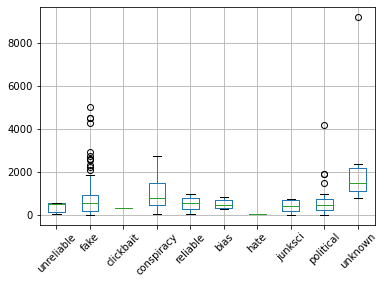

In [36]:
type_token_relation(df)

unreliable    0.007411
fake          0.004505
clickbait     0.000000
conspiracy    0.003574
reliable      0.001008
bias          0.005705
hate          0.000000
junksci       0.013840
political     0.002906
unknown       0.001769
dtype: float64

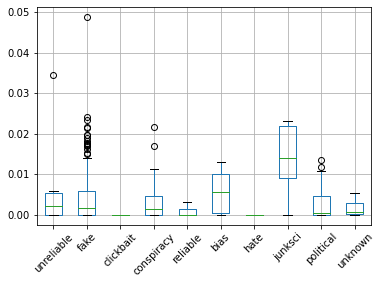

In [37]:
type_URLfreq_relation(df)

fake          155
conspiracy     31
political      23
unreliable      6
bias            6
junksci         6
unknown         6
reliable        3
clickbait       1
hate            1
Name: type, dtype: int64

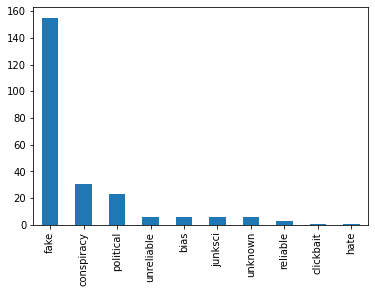

In [38]:
type_distribution(df)

In [39]:
domain_type_relation(df)

[('beforeitsnews.com', {'fake': 155}),
 ('canadafreepress.com', {'conspiracy': 24}),
 ('washingtonexaminer.com', {'political': 17}),
 ('awarenessact.com', {'conspiracy': 6}),
 ('naturalnews.com', {'junksci': 5}),
 ('strategic-culture.org', {'unknown': 4}),
 ('christianpost.com', {'reliable': 3}),
 ('city-journal.org', {'political': 2}),
 ('vdare.com', {'bias': 2}),
 ('undergroundhealth.com', {'unknown': 2}),
 ('alternet.org', {'political': 2}),
 ('awm.com', {'unreliable': 2}),
 ('breitbart.com', {'political': 1}),
 ('anonhq.com', {'unreliable': 1}),
 ('americanlookout.com', {'bias': 1}),
 ('washingtonsblog.com', {'bias': 1}),
 ('21stcenturywire.com', {'conspiracy': 1}),
 ('unz.com', {'bias': 1}),
 ('nationalreview.com', {'political': 1}),
 ('collectivelyconscious.net', {'junksci': 1}),
 ('breakpoint.org', {'unreliable': 1}),
 ('barenakedislam.com', {'hate': 1}),
 ('charismanews.com', {'bias': 1}),
 ('blackagendareport.com', {'unreliable': 1}),
 ('bipartisanreport.com', {'clickbait': 1}

## WIKINEWS SCRAPER

In [153]:
def create_soup(url):
    site = requests.get(url)
    return bs(site.text, "html.parser")

soup = create_soup('https://en.wikinews.org/wiki/Category:Politics_and_conflicts')

assigned_letters = "ABCDEFGHIJKLMNOPRSTUVWZABCDEFGHIJKLMNOPRSTUVWZ"[21%23:21%23+10]

In [206]:
def valid_links(soup):
    links=[]
    def is_valid(tag):
        return tag.name == 'a' and tag.get('title')[0] in assigned_letters
    section = {'id':"mw-pages"}
    subsection = {'class':"mw-category mw-category-columns"}
    for link in soup.find('div', section).find('div', subsection).find_all(is_valid):
        links.append("https://en.wikinews.org" + link.get('href'))
    return links

def next_page_url(soup):
    return "https://en.wikinews.org" + soup.find('a', string="next page").get('href')
    
def no_more_pages(soup):
    return soup.find('a', string="next page") is None

def get_links(soup, links):
    links += valid_links(soup)

    if no_more_pages(soup):
        return links
    else:
        next_soup = create_soup(next_page_url(soup))
        return get_links(next_soup, links)
    

In [207]:
links = get_links(soup, [])
len(links)

3085

In [208]:
def content_parser(soup):
    publish_date = ""
    content = ""

    terminators = ('Have an opinion on this story', 'Share this', 'This article has passed through community review',
        'This page is archived')

    for tag in soup.find('div', {'id':"bodyContent"}).find('div', {'class':"mw-parser-output"}).find_all(['p','dl']):
        datetag = tag.find('strong', {'class': "published"})
        
        if tag.text.startswith(terminators):
            break
        elif datetag != None:
            publish_date = datetag.span['title']
            content += tag.text
            content = content[len(datetag.text):] 
        else:
            content += (tag.text + "\n")
    
    return content, publish_date

def footer_parser(soup):
    modified_date = ""
    modified_tag = soup.find('li', {'id':"footer-info-lastmod"})
    if modified_tag != None:
        modified_text = modified_tag.text
        dates_from_text = list(datefinder.find_dates(modified_text))
        if len(dates_from_text) > 0:
            modified_date = dates_from_text[0].strftime('%Y-%m-%d')
    
    return modified_date

def source_parser(soup):
    sources = []
    for tag in soup.find_all('span', {'class':"sourceTemplate"}):
        source_text = tag.find('i')
        if source_text != None:
            sources.append(source_text.text)
    
    return sources

def categories_parser(soup):
    categories = []

    # Remove common categories
    excluded = ['','Published', 'Archived', 'Politics and conflicts']

    for tag in soup.find('div', {'id':"mw-normal-catlinks"}).find_all('li'):
        if tag.text not in excluded:
            categories.append(tag.text)
    
    # Remove date category
    if len(list(datefinder.find_dates(categories[0]))) > 0:
        categories = categories[1:]

    return categories
    

def scrape(url):
    soup = create_soup(url)

    title = soup.find('h1', {'id':"firstHeading"}).text

    content, publish_date = content_parser(soup)

    modified_date = footer_parser(soup)

    sources = source_parser(soup)

    categories = categories_parser(soup)

    return title, publish_date, modified_date, sources, categories, content

In [209]:
scraped_data = pd.DataFrame(map(scrape, links), columns = ['title', 'publish_date', 'modified_date', 'sources', 'categories', 'content'])

In [210]:
scraped_data.to_csv('wikinews.csv', encoding='utf-8')

## DATABASE FAKENEWS CORPUS

In [ ]:
df_fnc = pd.read_csv("1mio-raw.csv", delimiter = ",", nrows = 10000)